In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os

from pyproj import Transformer
import numpy as np
import pandas as pd

BASE_DIR = os.getcwd()

csv_filepath = os.path.join(BASE_DIR, 'data', 'learn_data', 'Basket_1.csv')

df = pd.read_csv(csv_filepath, delimiter=',', header=1, skiprows=300)
new_columns = ['Time', 
                'Accelerometer x', 'Accelerometer y', 'Accelerometer z',
                'Gyroscope x', 'Gyroscope y', 'Gyroscope z',
                'Magnetometer x', 'Magnetometer y', 'Magnetometer z',
                'Orientation x', 'Orientation y', 'Orientation z',
                'Pressure', 
                'Latitude', 'Longitude', 'Altitude', 'Speed_GPS']  

#열(column) 이름 재정의
df.columns = new_columns


df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%d %H:%M:%S.%f')
start_time_dt = df['Time'].iloc[0]
df['Elapsed Time'] = (df['Time'] - start_time_dt).dt.total_seconds()

time_diff = df['Elapsed Time'].diff()

mean_interval = time_diff.mean()


logging_freq = 1 / mean_interval
print(f"Logging Frequency: {logging_freq:.2f} Hz")


Logging Frequency: 50.00 Hz


In [2]:
def llh_to_ecef(lat, lon, alt=0.0):
    transformer = Transformer.from_crs("epsg:4979", "epsg:4978", always_xy=True)
    return transformer.transform(lon, lat, alt)

def ecef_to_en(x, y, z, x0, y0, z0, lat0, lon0):
    dx, dy, dz = x - x0, y - y0, z - z0
    lat0 = np.radians(lat0)
    lon0 = np.radians(lon0)
    # 회전행렬 앞 2행만 사용 → E, N만 계산
    t = np.array([
        [-np.sin(lon0),  np.cos(lon0), 0],
        [-np.sin(lat0)*np.cos(lon0), -np.sin(lat0)*np.sin(lon0), np.cos(lat0)],
    ])
    en = t @ np.array([dx, dy, dz])
    return en[0], en[1]  # E, N만 반환

def gps_to_en(df):
    lat0 = df['Latitude'].iloc[0]
    lon0 = df['Longitude'].iloc[0]
    x0, y0, z0 = llh_to_ecef(lat0, lon0, 0.0)

    en_coords = []
    for lat, lon in zip(df['Latitude'], df['Longitude']):
        x, y, z = llh_to_ecef(lat, lon, 0.0)  # 고도 0으로 고정
        e, n = ecef_to_en(x, y, z, x0, y0, z0, lat0, lon0)
        en_coords.append((e, n))

    en_array = np.array(en_coords)
    df['E'], df['N'] = en_array[:, 0], en_array[:, 1]
    df['Delta X'] = df['E'].diff().fillna(0)
    df['Delta Y'] = df['N'].diff().fillna(0)
    return df

df = gps_to_en(df)

print(df[['Latitude', 'Longitude', 'E', 'N', 'Delta X', 'Delta Y']].head(10))



    Latitude   Longitude    E    N  Delta X  Delta Y
0  37.887785  127.737657  0.0  0.0      0.0      0.0
1  37.887785  127.737657  0.0  0.0      0.0      0.0
2  37.887785  127.737657  0.0  0.0      0.0      0.0
3  37.887785  127.737657  0.0  0.0      0.0      0.0
4  37.887785  127.737657  0.0  0.0      0.0      0.0
5  37.887785  127.737657  0.0  0.0      0.0      0.0
6  37.887785  127.737657  0.0  0.0      0.0      0.0
7  37.887785  127.737657  0.0  0.0      0.0      0.0
8  37.887785  127.737657  0.0  0.0      0.0      0.0
9  37.887785  127.737657  0.0  0.0      0.0      0.0


순수 회전 이벤트별 누적 각도(deg):
[-0.444074003365816, 3.1011913661469177, 2.6911000824824023, 4.591206316800935, 19.179712780705348, 54.46955599275273, 84.44725998062594, 97.16861007247613, 96.42028865043498, 95.6677614265914, 94.59228980153931, 93.14459172533607, 90.99413921479125, 89.20593081838372, 88.94435814696726, 90.97868396150854, 91.12141926206579, 89.25995920182557, 86.20944040976384, 82.3677506470953, 81.56351023541525, 86.87391297999008, 98.26857971890983, 128.3947325776149, 162.46244621216192, 182.03533101049422, 186.9183233020796, 183.4886578750563, 181.22537011523102, 180.86901617384666, 182.0823470251272, 181.23119808703865, 196.37224054118127, 230.79792279936538, 256.10668671365204, 273.78553087142103, 274.2001127624889, 272.9228721689847, 271.78371742580384, 271.9011123018424, 272.38116494635756, 271.5476486875853, 267.33773501113075, 266.2020238393849, 266.21911277092295, 266.6879504872896, 266.6246165757557, 268.28334493558003, 266.6729579030179, 267.5366456503868, 267.731493

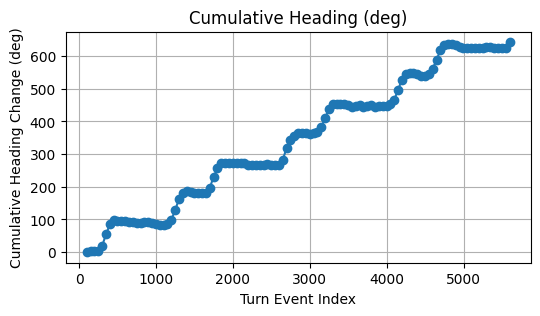

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ─────────────────────────────────────────────────────────────
# (1) 전제: df 에 이미 'E', 'N' 열이 있습니다.
# 예) df = gps_to_en(df)  처럼 ENU 변환이 끝난 상태
# ─────────────────────────────────────────────────────────────

# 1) ΔX, ΔY, ΔD 계산
df['Delta X'] = df['E'].diff().fillna(0)
df['Delta Y'] = df['N'].diff().fillna(0)
df['Delta D'] = np.sqrt(df['Delta X']**2 + df['Delta Y']**2)

# 2) 실제 이동이 일어난 인덱스만 골라내기 (GPS가 바뀐 시점)
move_mask = df['Delta D'] > 0
df_move = df[move_mask].copy()

df['Pure Speed'] = df['Delta D'].where(move_mask, 0)

# 3) 그 구간에서 절대 Heading 계산 (라디안)
df_move['Heading'] = np.arctan2(df_move['Delta Y'], df_move['Delta X'])

# 4) Heading Change 계산
hc = df_move['Heading'].diff().fillna(0)
df_move['Heading Change'] = ((hc + np.pi) % (2 * np.pi)) - np.pi

# 5) 원본 df 에 “순수한” Heading Change 매핑
df['Pure Heading Change'] = 0.0
df.loc[df_move.index, 'Pure Heading Change'] = df_move['Heading Change']

# (선택) 도 단위로 보고 싶다면
df['Pure Heading Change (deg)'] = np.degrees(df['Pure Heading Change'])

# ─────────────────────────────────────────────────────────────
# 6) 결과 확인: 누적 회전량 계산 및 시각화
#    - change_events: 0이 아닌 이벤트들만
# ─────────────────────────────────────────────────────────────
change_events = df['Pure Heading Change (deg)'][df['Pure Heading Change (deg)'] != 0]
cumulative = change_events.cumsum()

print("순수 회전 이벤트별 누적 각도(deg):")
print(cumulative.to_list())

plt.figure(figsize=(6,3))
plt.plot(cumulative, marker='o')
plt.title('Cumulative Heading (deg)')
plt.xlabel('Turn Event Index')
plt.ylabel('Cumulative Heading Change (deg)')
plt.grid(True)
plt.show()


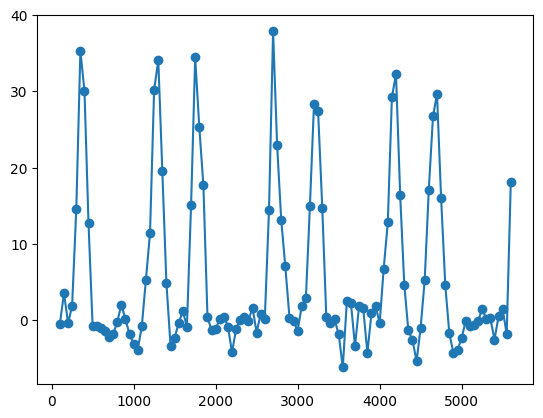

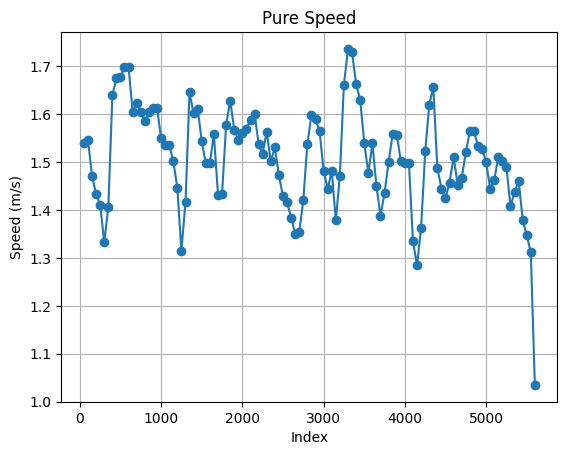

In [8]:
plt.plot(df['Pure Heading Change (deg)'][df['Pure Heading Change (deg)'] != 0], marker='o')
plt.show()

non_0_speed = df['Pure Speed'][df['Pure Speed'] != 0]

plt.plot(non_0_speed, marker='o')
plt.title('Pure Speed')
plt.xlabel('Index')
plt.ylabel('Speed (m/s)')
plt.grid(True)
plt.show()

In [ ]:
import numpy as np

# 1) 순수 회전 이벤트(0이 아닌)만 뽑아서 출력
events = df['Pure Heading Change (deg)'][df['Pure Heading Change (deg)'] != 0]
print("순수 회전 이벤트 (deg):")
print(events)

# 2) 인접한 이벤트들 간에 부호 반전이 있는지 검사
phc = df['Pure Heading Change (deg)']
opposite_pairs = []
for idx in phc.index[:-1]:
    a = phc.loc[idx]
    b = phc.loc[idx+1]
    if a != 0 and b != 0 and np.sign(a) != np.sign(b):
        opposite_pairs.append((idx, a, idx+1, b))

print("\n인접 이벤트 중 부호가 반대인 쌍:")
print(opposite_pairs or "없음 — ±6° 같은 쌍이 발견되지 않았습니다.")


순수 회전 이벤트 (deg):
99      -0.444074
149      3.545265
199     -0.410091
248      1.900106
299     14.588506
          ...    
5399    -2.550036
5449     0.554333
5498     1.457691
5548    -1.805874
5598    18.134615
Name: Pure Heading Change (deg), Length: 111, dtype: float64

인접 이벤트 중 부호가 반대인 쌍:
없음 — ±6° 같은 쌍이 발견되지 않았습니다.


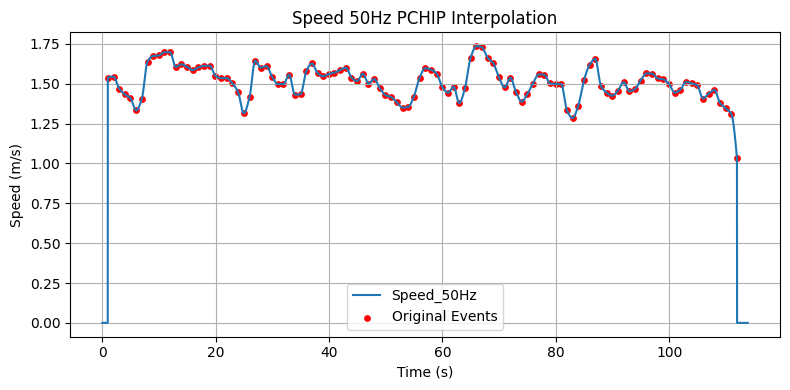

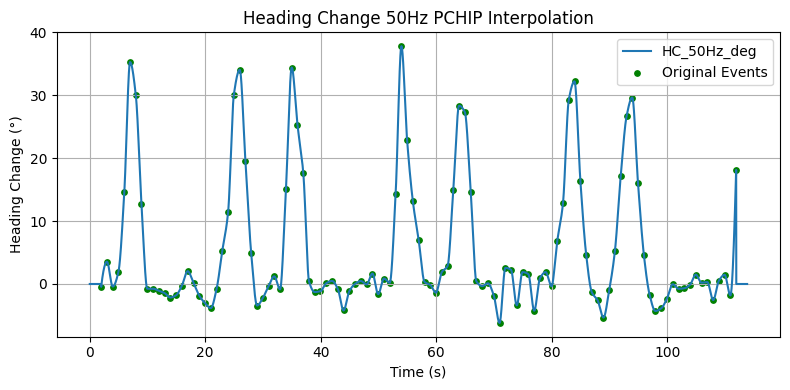

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator

# ─────────────────────────────────────────────────────────────
# 1) 이벤트 시점만 뽑아내기
# ─────────────────────────────────────────────────────────────
t_events = df.loc[df['Pure Speed'] != 0, 'Elapsed Time'].values
v_events = df.loc[df['Pure Speed'] != 0, 'Pure Speed'].values

t_hce    = df.loc[df['Pure Heading Change'] != 0, 'Elapsed Time'].values
hc_events= df.loc[df['Pure Heading Change'] != 0, 'Pure Heading Change'].values

# ─────────────────────────────────────────────────────────────
# 2) PCHIP 보간기 생성 (경계 외삽은 0으로 채우기 위해 extrapolate=False)
# ─────────────────────────────────────────────────────────────
speed_pchip = PchipInterpolator(t_events, v_events, extrapolate=False)
hc_pchip    = PchipInterpolator(t_hce, hc_events, extrapolate=False)

# ─────────────────────────────────────────────────────────────
# 3) 전체 시간축에 평가
# ─────────────────────────────────────────────────────────────
t_full   = df['Elapsed Time'].values

v_interp = speed_pchip(t_full)
hc_interp= hc_pchip(t_full)

# extrapolate=False 로 설정했기 때문에
# t_full가 이벤트 범위 밖인 구간은 NaN 이 됩니다.
# 이걸 0으로 채워줍니다.
v_interp = np.nan_to_num(v_interp, nan=0.0)
hc_interp= np.nan_to_num(hc_interp, nan=0.0)

# ─────────────────────────────────────────────────────────────
# 4) DF에 저장
# ─────────────────────────────────────────────────────────────
df['Speed_50Hz'] = v_interp
df['HC_50Hz']    = hc_interp

# 5) (선택) 라디안→도 변환 컬럼
df['HC_50Hz_deg'] = np.degrees(df['HC_50Hz'])

# ─────────────────────────────────────────────────────────────
# 6) 결과 시각화
# ─────────────────────────────────────────────────────────────
plt.figure(figsize=(8,4))
plt.plot(df['Elapsed Time'], df['Speed_50Hz'], label='Speed_50Hz')
plt.scatter(t_events, v_events, color='red', s=15, label='Original Events')
plt.title('Speed 50Hz PCHIP Interpolation')
plt.xlabel('Time (s)')
plt.ylabel('Speed (m/s)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(df['Elapsed Time'], df['HC_50Hz_deg'], label='HC_50Hz_deg')
plt.scatter(t_hce, np.degrees(hc_events), color='green', s=15, label='Original Events')
plt.title('Heading Change 50Hz PCHIP Interpolation')
plt.xlabel('Time (s)')
plt.ylabel('Heading Change (°)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
